Neural machine translation, Bangla to English
We have trained a sequence to sequence model to translate Bangla words and short texts to English


In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

We are using a Bengali-English dataset from anki.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/My Drive/Datasets/

/content/drive/My Drive/Datasets


In [4]:
ls

ben/  ben.txt  training_checkpoints/


In [5]:


# path_to_file = os.path.dirname(path_to_zip)+"/ben-eng/ben.txt"
corpus_name = "ben"
corpus = os.path.join("/content/drive/My Drive/Datasets/", corpus_name)

path_to_file = os.path.join(corpus, "ben.txt")


In [6]:
def printLines(file, n=15):
    with open(file, 'r', encoding='utf-8') as path_to_file:
        lines = path_to_file.readlines()
    for line in lines[:n]:
        print(line)
        
printLines(path_to_file)

Go.	যাও।

Go.	যান।

Go.	যা।

Run!	পালাও!

Run!	পালান!

Who?	কে?

Fire!	আগুন!

Help!	বাঁচাও!

Help!	বাঁচান!

Stop!	থামুন!

Stop!	থামো!

Stop!	থাম!

Hello!	নমস্কার!

I see.	বুঝলাম।

I try.	আমি চেষ্টা করি।



In [7]:
# Converting the unicode file to ascii
def unicode_to_ascii(string, accents=('COMBINING ACUTE ACCENT', 'COMBINING GRAVE ACCENT', 'COMBINING TILDE')):
    accents = set(map(unicodedata.lookup, accents))
    chars = [c for c in unicodedata.normalize('NFD', string) if c not in accents]
    return unicodedata.normalize('NFC', ''.join(chars))


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())
  # creating a space between a word and the punctuation following it
  w = re.sub(r"([.!?])", r" \1", w)
  w = re.sub(r"\s", r" ", w).strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

#Process Sentences

In [8]:
bn_sentence = u"আমি চেষ্টা করেছিলাম।"
en_sentence = u"I tried."
print(preprocess_sentence(bn_sentence))
print(preprocess_sentence(en_sentence))


<start> আমি চেষ্টা করেছিলাম। <end>
<start> i tried . <end>


In [9]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, BANGLA]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [10]:
bn, en = create_dataset(path_to_file, None)
print(bn[-1])
print(en[-1])

<start> i thought doing this would be easy, but we've been working all day and we're still not finished . <end>
<start> আমি ভেবেছিলাম এটা করা সহজ হবে, কিন্তু আমরা সারাদিন ধরে কাজ করেছি আর এখনো শেষ করে উঠতে পারিনি। <end>


We will use keras Tokernizer to split our texts into words

In [12]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

Here we will create cleaned input, output pairs

In [14]:
def load_dataset(path, num_examples=None):

  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

Experiment with size of dataset 

We tried to experiment with the size of the dataset to see different results. Using smaller portion of dataset led to faster computation but lower translation accuracy.

In [15]:
# experimenting with the size of dataset
num_examples = 5000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

###We created training and validation sets using an 80-20 split

In [17]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

3473 3473 869 869


In [19]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [20]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
5 ----> টম
261 ----> চেঁচালো।
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
6 ----> tom
308 ----> yelled
3 ----> .
2 ----> <end>


Creating a tf.data dataset

In [22]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64 #mini batch
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [24]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 20]), TensorShape([64, 22]))

###Forming the encoder and decoder model

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">



* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder



In [25]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [26]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 20, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [27]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [28]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 20, 1)


In [29]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [30]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 1961)


Defining the optimizer and the loss function

In [31]:
optimizer = tf.keras.optimizers.Adam() #Adam optimization is a stochastic gradient descent method
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [32]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

Training the model

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [33]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [34]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.0944
Epoch 1 Loss 1.5308
Time taken for 1 epoch 363.4778416156769 sec

Epoch 2 Batch 0 Loss 1.2753
Epoch 2 Loss 1.2418
Time taken for 1 epoch 327.242427110672 sec

Epoch 3 Batch 0 Loss 1.1856
Epoch 3 Loss 1.1264
Time taken for 1 epoch 325.65964007377625 sec

Epoch 4 Batch 0 Loss 1.0985
Epoch 4 Loss 1.0219
Time taken for 1 epoch 330.34140944480896 sec

Epoch 5 Batch 0 Loss 0.9229
Epoch 5 Loss 0.9203
Time taken for 1 epoch 324.44483757019043 sec

Epoch 6 Batch 0 Loss 0.8353
Epoch 6 Loss 0.8375
Time taken for 1 epoch 328.07269310951233 sec

Epoch 7 Batch 0 Loss 0.7042
Epoch 7 Loss 0.7673
Time taken for 1 epoch 328.1085674762726 sec

Epoch 8 Batch 0 Loss 0.6801
Epoch 8 Loss 0.6957
Time taken for 1 epoch 328.32153844833374 sec

Epoch 9 Batch 0 Loss 0.5878
Epoch 9 Loss 0.6283
Time taken for 1 epoch 326.4286494255066 sec

Epoch 10 Batch 0 Loss 0.5658
Epoch 10 Loss 0.5650
Time taken for 1 epoch 327.3130900859833 sec



## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [35]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [36]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [37]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [38]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> উনি এখনো আসেননি। <end>
Predicted translation: he hasn't come yet . <end> 


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2441 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2472 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2495 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2447 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2507 missing from current font.
  font.set_text(s

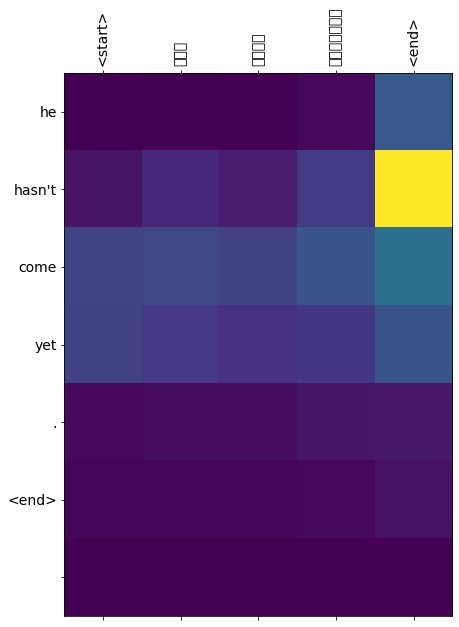

In [60]:
translate(u'উনি এখনো আসেননি।')

Input: <start> এখানে দাঁড়ান। <end>
Predicted translation: he can speak french . <end> 


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2447 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2472 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2503 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2470 missing from current font.
  font.set_text(s

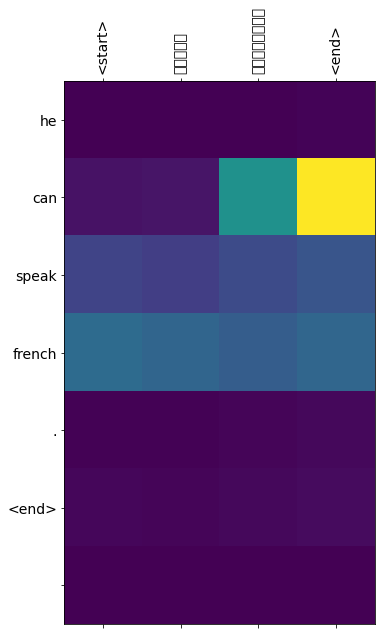

In [81]:
translate(u'এখানে দাঁড়ান।')

Input: <start> আমার মাথা ব্যাথা করছে। <end>
Predicted translation: my head aches . <end> 


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2438 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2478 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2476 missing from current font.
  font.set_text(s

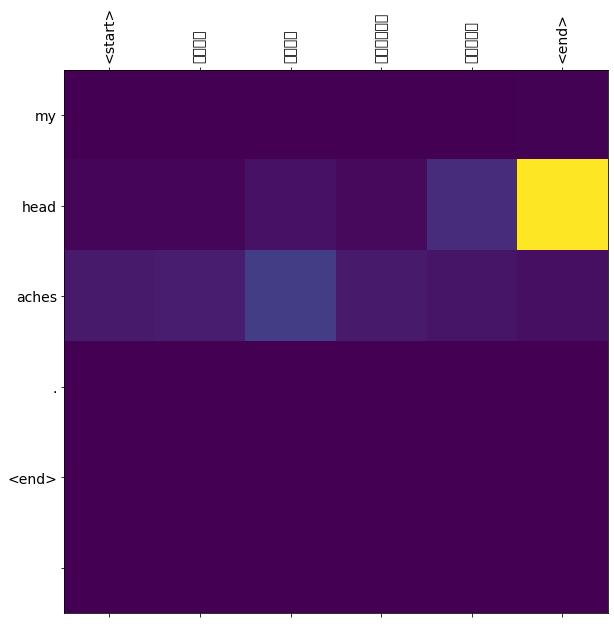

In [ ]:
translate(u'আমার মাথা ব্যাথা করছে।')

Input: <start> আমি যাবো। <end>
Predicted translation: i will go . <end> 


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2438 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2478 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2495 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2479 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2476 missing from current font.
  font.set_text(s

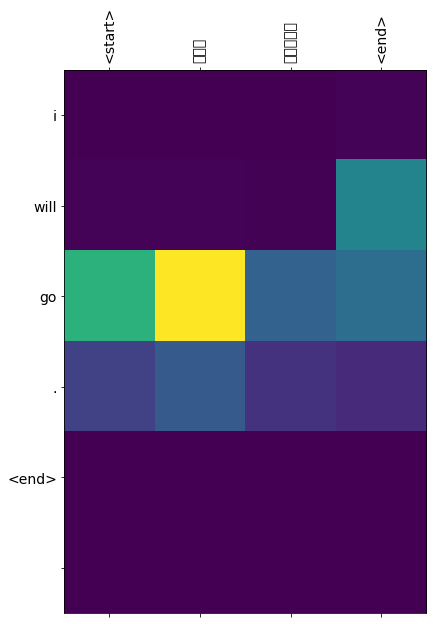

In [ ]:

translate(u'আমি যাবো।')